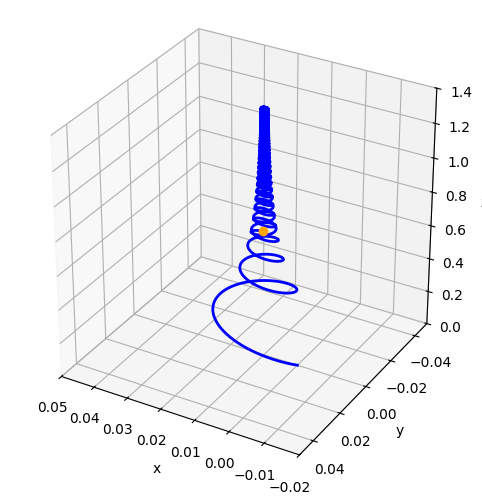

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from numba import njit

#Parameters
q, m = 1.0, 1.0
B0, L, alpha = 8.0, 2.0, 40.0
v0 = np.array([0.1, 0.1, 0.6])

#Magnetic momentum using the initial velocity
v_perp2 = v0[0]**2 + v0[1]**2
mu = m * v_perp2 / (2 * B0)

#Lorentz force and mirror effect
@njit
def compute_k(y):
    k = np.empty(6, np.float64)
    x, y_, z = y[0], y[1], y[2]
    vx, vy, vz = y[3], y[4], y[5]

    Bz = B0 * (1 + alpha * (z/L)**2)
    dBz_dz = B0 * 2 * alpha * z / L**2  #dB/dz

    #r' = v
    k[0], k[1], k[2] = vx, vy, vz

    #dv/dt = (q/m) v × B + mirror force
    k[3] = (q/m) * vy * Bz
    k[4] = -(q/m) * vx * Bz
    k[5] = -(mu / m) * dBz_dz  #mirror force
    return k

@njit
def integrate_mirror(y0, dt, N_steps):
    traj = np.zeros((N_steps, 6))
    traj[0] = y0
    for i in range(1, N_steps):
        y = traj[i-1]
        k1 = compute_k(y)
        k2 = compute_k(y + 0.5*dt*k1)
        k3 = compute_k(y + 0.5*dt*k2)
        k4 = compute_k(y + dt*k3)
        traj[i] = y + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)
    return traj

#Other initial conditions and time paraameters
r0 = np.array([0.0, 0.0, 0.0])
y0 = np.hstack((r0, v0))
dt = 0.002
N_steps = 3000
traj = integrate_mirror(y0, dt, N_steps)

#Figure and animation setup
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')

ax.set_box_aspect((1,1,1))
ax.set_xlim(-0.02, 0.05)
ax.set_ylim(-0.05, 0.05)
ax.set_zlim(0, 1.4)
ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('z')
ax.view_init(elev=30, azim=120)

line, = ax.plot([], [], [], lw=2, color='blue')
point, = ax.plot([], [], [], 'o', color='orange')

def init():
    line.set_data([], []); line.set_3d_properties([])
    point.set_data([], []); point.set_3d_properties([])
    return line, point

def update(frame):
    xs = traj[:frame+1, 0]
    ys = traj[:frame+1, 1]
    zs = traj[:frame+1, 2]
    line.set_data(xs, ys)
    line.set_3d_properties(zs)
    point.set_data([traj[frame,0]], [traj[frame,1]])
    point.set_3d_properties([traj[frame,2]])
    return line, point

n_frames = 500
frame_inds = np.linspace(0, N_steps-1, n_frames, dtype=int)

ani = FuncAnimation(fig, update, frames=frame_inds, init_func=init, interval=20, blit=True)
writer = PillowWriter(fps=30)
ani.save('Magnetic_Mirror.gif', writer=writer)
